In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## *Exploratory data analysis*

In [2]:
# We import the data and take a look at it
df = pd.read_csv("train (1).csv")
df_test = pd.read_csv("test_x.csv")
df.head()


,Unnamed: 0,Hour,Minutes,Sensor_alpha,Sensor_beta,Sensor_gamma,Sensor_alpha_plus,Sensor_beta_plus,Sensor_gamma_plus,Insect
0,0,22,26,119.910995,242.838324,-316.819222,250.195048,-53.547777,-112.049983,2
1,1,10,16,-90.790536,-269.470767,-182.581844,95.394941,37.291944,48.525180,0
2,2,21,42,-20.028003,-147.070212,50.280872,-90.750386,-50.476556,85.399009,1
3,3,21,17,-21.258567,0.467070,-86.164153,-21.813529,-209.256006,16.291882,0
4,4,18,16,-58.154501,-13.051195,-156.501167,48.392938,-110.008860,-10.285138,2


#### Missing values

In [3]:
print(f"The number of missing values in the data is: {df.isna().sum().sum()}")

The number of missing values in the data is: 0


#### Balance in the data

In [31]:
df.Insect.value_counts()/df.shape[0]

0    0.502642
1    0.398943
2    0.098415
Name: Insect, dtype: float64

We can see that the data is imbalance: only the 9.8% of the entries correspond to the third specie of insect (Diptera). Using accuracy as the metric for our model will give us an unrealistic image of its performance. We will use F1-score as metric as it gives a more realistic description of the model performance.

In [5]:
df["Time"] = df["Hour"] * 60 + df["Minutes"]
df.head()
df.columns[5]

'Sensor_gamma'

#### Plots

We begin by plotting the position of the insect in every sensor to see how they distribute on each sensor

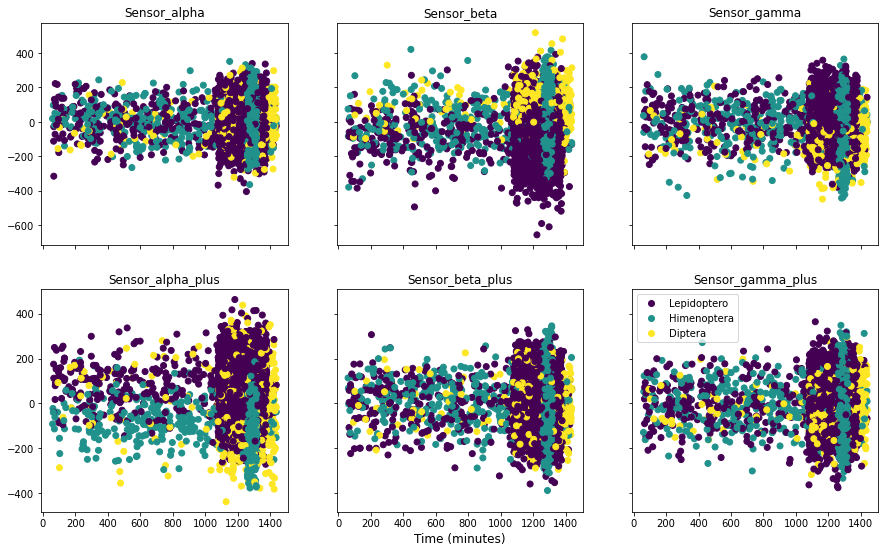

In [6]:
fig, axs = plt.subplots(2, 3, sharex='col', sharey='row')
fig.set_size_inches(15, 9)
for i in range(2):
    for j in range(3):
        column = df.columns[3*i + j + 3]
        scat=axs[i, j].scatter(df.Time, df[column], c=df.Insect, label='color')
        axs[i, j].set_title(f"{column}", fontsize=12)


axs[1, 1].set_xlabel("Time (minutes)", fontsize=12)
plt.legend(handles=scat.legend_elements()[0], 
           labels=["Lepidoptero", "Himenoptera", "Diptera"])
plt.show()


We can see that the insects are more separable in some sensors than in others. We will apply some feature selection tecniques 

We will now plot the frequency of each insect detection over time

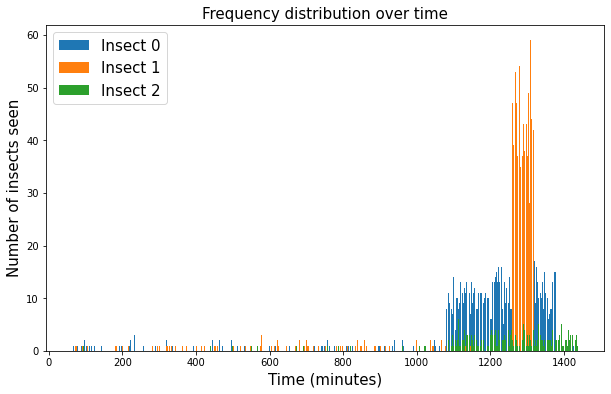

In [7]:
df_dist = df.groupby(["Time", "Insect"], as_index=False).count()

plt.figure(figsize=(10,6))
for i in range(3): 
    plt.bar(df_dist[df_dist.Insect == i].Time, df_dist[df_dist.Insect == i]["Hour"], label=f"Insect {i}")

plt.xlabel("Time (minutes)", fontsize=15)
plt.ylabel("Number of insects seen", fontsize=15)
plt.title("Frequency distribution over time", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Time seems to be a relevant feature as some insect species are more likely to be seeing at certain hours.

## *Models*

 #### Classification models

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

features = ['Time', 'Sensor_beta', 'Sensor_gamma', 'Sensor_alpha_plus']

target = 'Insect'

X = df[features]
y = df[target]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

model = XGBClassifier(eta=0.3, gamma=0, max_depth=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"The accuracy of the model is: {accuracy}")
print(f"The accuracy for each class is: {cm.diagonal()/cm.sum(axis=1)}")
print(f"The F1 score of the model is: {f1}")

[[662  43  10]
 [ 29 515   2]
 [ 42  12  86]]
The accuracy of the model is: 0.9014989293361885
The accuracy for each class is: [0.92587413 0.94322344 0.61428571]
The F1 score of the model is: 0.8533309282048628


In [143]:
from sklearn.model_selection import cross_val_score

features = ['Time', 'Sensor_beta', 'Sensor_gamma', 'Sensor_alpha_plus']

target = 'Insect'

X = df[features]
y = df[target]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


model = XGBClassifier(eta=0.3, gamma=0, max_depth=10)
cv = cross_val_score(model, X_scaled, y, scoring="f1_macro", cv = 10)

print("The f1_macro score of the model using cross validation is: {:.2f} +- {:.2f}".format(cv.mean(), cv.std()))

The f1_macro score of the model using cross validation is: 0.86 +- 0.01


In [149]:
# FEATURE SELECTION USING RECURSIVE FEATURE ELIMINATION
from sklearn.feature_selection import RFE

features = ['Time', 'Sensor_alpha', 'Sensor_beta',
       'Sensor_gamma', 'Sensor_alpha_plus', 'Sensor_beta_plus',
       'Sensor_gamma_plus']

target = 'Insect'

X = df[features]
y = df[target]

model = XGBClassifier(eta=0.3, gamma=0, max_depth=10)
selector = RFE(model, n_features_to_select=4, step=1)

selector.fit(X, y)
print(selector.get_feature_names_out())

['Time' 'Sensor_beta' 'Sensor_gamma' 'Sensor_alpha_plus']


#### Over-sampling methods to deal with the imbalanced data

In [53]:
from imblearn.ensemble import BalancedRandomForestClassifier


classifier = BalancedRandomForestClassifier(n_estimators=150, sampling_strategy={0:1500, 1:500, 2:555}, replacement=False)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"The accuracy of the model is: {accuracy}")
print(f"The accuracy for each class is: {cm.diagonal()/cm.sum(axis=1)}")
print(f"The F1 score of the model is: {f1}")

[[656  27  31]
 [ 71 467  15]
 [ 27  10  97]]
The accuracy of the model is: 0.8708065667380442
The accuracy for each class is: [0.91876751 0.84448463 0.7238806 ]
The F1 score of the model is: 0.8259089680751984


#### Unsupervised learning

In [137]:
from sklearn.svm import SVC
features = ['Time', 'Sensor_beta', 'Sensor_gamma', 'Sensor_alpha_plus']

target = 'Insect'

X = df[features]
y = df[target]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

model = SVC(C=10,  kernel='rbf', degree=3, class_weight={0:2, 1:2, 2:3})
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"The accuracy of the model is: {accuracy}")
print(f"The accuracy for each class is: {cm.diagonal()/cm.sum(axis=1)}")
print(f"The F1 score of the model is: {f1}")

[[606  92   5]
 [ 27 519   1]
 [ 43  16  92]]
The accuracy of the model is: 0.8686652391149179
The accuracy for each class is: [0.86201991 0.9488117  0.60927152]
The F1 score of the model is: 0.8340034348061822


In [152]:
features = ['Time', 'Sensor_beta', 'Sensor_gamma', 'Sensor_alpha_plus']

target = 'Insect'

X = df[features]
y = df[target]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


model = SVC(C=10,  kernel='rbf', class_weight={0:2, 1:2, 2:3})
cv = cross_val_score(model, X_scaled, y, scoring="f1_macro", cv = 10)

print("The f1_macro score of the model using cross validation is: {:.2f} +- {:.2f}".format(cv.mean(), cv.std()))

The f1_macro score of the model using cross validation is: 0.83 +- 0.02


#### Neural Networks

In [151]:
import tensorflow as tf

In [160]:

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_dim=4, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
y_train = tf.keras.utils.to_categorical(y_train)
print(X_train.shape, y_train.shape)
model.fit(X_train, y_train, verbose=2, epochs=50, batch_size=16)
y_pred =np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
print(f"The accuracy of the model is: {accuracy}")
print(f"The accuracy for each class is: {cm.diagonal()/cm.sum(axis=1)}")
print(f"The F1 score of the model is: {f1}")

              precision    recall  f1-score   support

           0       0.92      0.95      0.93       718
           1       0.93      0.97      0.95       551
           2       0.93      0.64      0.76       132

    accuracy                           0.93      1401
   macro avg       0.93      0.85      0.88      1401
weighted avg       0.93      0.93      0.92      1401



In [163]:
f1s = []
for i in range(10):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, input_dim=4, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
    y_train = tf.keras.utils.to_categorical(y_train)
    model.fit(X_train, y_train, verbose=0, epochs=50, batch_size=16)
    y_pred =np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"The accuracy of the model is: {accuracy}")
    print(f"The accuracy for each class is: {cm.diagonal()/cm.sum(axis=1)}")
    print(f"The F1 score of the model is: {f1}")
    f1s.append(f1)

print("The f1_macro score of the model using cross validation is: {:.2f} +- {:.2f}".format(np.mean(f1s), np.std(f1s)))

44/44 [==============================] - 0s 1ms/step
The accuracy of the model is: 0.9014989293361885
The accuracy for each class is: [0.93069307 0.95072993 0.57534247]
The F1 score of the model is: 0.8474527852611171
44/44 [==============================] - 0s 1ms/step
The accuracy of the model is: 0.9179157744468237
The accuracy for each class is: [0.92577031 0.97277677 0.65441176]
The F1 score of the model is: 0.8693722955102441
44/44 [==============================] - 0s 1ms/step
The accuracy of the model is: 0.9157744468236974
The accuracy for each class is: [0.93370166 0.96892139 0.59230769]
The F1 score of the model is: 0.8573740936939428
44/44 [==============================] - 0s 1ms/step
The accuracy of the model is: 0.9300499643112062
The accuracy for each class is: [0.94875346 0.97222222 0.66906475]
The F1 score of the model is: 0.8864007586292825
44/44 [==============================] - 0s 2ms/step
The accuracy of the model is: 0.9200571020699501
The accuracy for each clas

## Final model train and prediction of the test dataset labels

Given the results previously displayed, the best model has turned out to be the Neural Network. After applying some hyperparameter tunning on its hyperparameters and on its structure, the best f1 macro score has turned out to be of 